In [2]:
import numpy as np
import torch
import utils, parameters

(10000, 40)


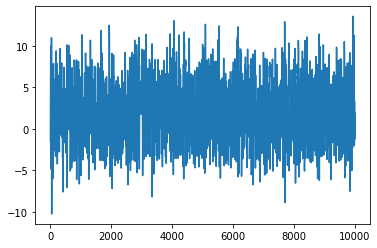

In [3]:
from scipy.integrate import solve_ivp

def Lorenz_96(S,t,F,J):
    """ Lorenz-96 dynamical model. """
    x = np.zeros(J);
    x[0] = (S[1]-S[J-2])*S[J-1]-S[0];
    x[1] = (S[2]-S[J-1])*S[0]-S[1];
    x[J-1] = (S[0]-S[J-3])*S[J-2]-S[J-1];
    for j in range(2,J-1):
        x[j] = (S[j+1]-S[j-2])*S[j-1]-S[j];
    dS = x.T + F;
    return dS

dt_int  = parameters.step_size
len_int = 10000#40000

x0 = 40 * np.ones(parameters.J);
x0[np.int(np.around(parameters.J/2))] = x0[np.int(np.around(parameters.J/2))] + 0.01
S = solve_ivp(fun=lambda t,y: Lorenz_96(y, t, parameters.F, parameters.J), 
              t_span=[0.,5+0.000001], y0=x0, first_step=dt_int, t_eval=np.arange(0, 5+0.000001, dt_int), method='RK45')

x0 = S.y[:,-1]
tt = np.arange(dt_int, len_int*dt_int+0.000001, dt_int)
S = solve_ivp(fun=lambda t,y: Lorenz_96(y, t, parameters.F, parameters.J), 
              t_span=[dt_int, len_int*dt_int+0.000001], y0=x0, first_step=dt_int, t_eval=tt, method='RK45')
S = S.y.transpose()

import matplotlib.pyplot as plt 

print(S.shape)
plt.plot(S[:10000, 0])

In [4]:
from sklearn.feature_extraction import image

ratio    = parameters.da_interval
sigNoise = parameters.sigNoise

# extract subsequences
dataTrainingNoNaN = image.extract_patches_2d(S[:7500,:], (parameters.window_len,parameters.J), parameters.NbTraining)
dataValNoNaN      = image.extract_patches_2d(S[7500:,:], (parameters.window_len,parameters.J), parameters.NbVal)

dataTraining    = np.zeros((dataTrainingNoNaN.shape))
dataTraining[:] = float('nan')
dataVal         = np.zeros((dataValNoNaN.shape))
dataVal[:]      = float('nan')

for ii in range(0, dataTraining.shape[1], ratio):
    indrand = np.random.permutation(dataTraining.shape[2])[0:int(0.5*dataTraining.shape[2])]
    dataTraining[:, ii, indrand] = dataTrainingNoNaN[:, ii, indrand]

for ii in range(0, dataTraining.shape[1], ratio):
    indrand = np.random.permutation(dataTraining.shape[2])[0:int(0.5*dataTraining.shape[2])]
    dataVal[:, ii, indrand] = dataValNoNaN[:, ii, indrand]
    
maskTraining = (dataTraining == dataTraining).astype('float')
maskVal      = ( dataVal     ==  dataVal    ).astype('float')

dataTraining = np.nan_to_num(dataTraining)
dataVal      = np.nan_to_num(dataVal)

# Permutation to have channel as #1 component
dataTraining      = np.moveaxis(dataTraining,-1,1)
maskTraining      = np.moveaxis(maskTraining,-1,1)
dataTrainingNoNaN = np.moveaxis(dataTrainingNoNaN,-1,1)

dataVal      = np.moveaxis(dataVal,-1,1)
maskVal      = np.moveaxis(maskVal,-1,1)
dataValNoNaN = np.moveaxis(dataValNoNaN,-1,1)

## raw data
X_train         = dataTrainingNoNaN
X_train_missing = dataTraining
mask_train      = maskTraining

X_val          = dataValNoNaN
X_val_missing  = dataVal
mask_val       = maskVal

## normalized data
meanTr          = np.mean(X_train_missing[:]) / np.mean(mask_train) 

x_train_missing = X_train_missing - meanTr
x_val_missing   = X_val_missing - meanTr

stdTr           = np.sqrt( np.mean( X_train_missing**2 ) / np.mean(mask_train) )
x_train_missing = x_train_missing / stdTr
x_val_missing   = x_val_missing / stdTr

x_train = (X_train - meanTr) / stdTr
x_val   = (X_val - meanTr) / stdTr

X_train_obs = X_train_missing + sigNoise * maskTraining * np.random.randn(X_train_missing.shape[0],X_train_missing.shape[1],X_train_missing.shape[2])
X_val_obs   = X_val_missing   + sigNoise * maskVal * np.random.randn(X_val_missing.shape[0],X_val_missing.shape[1],X_val_missing.shape[2])

x_train_obs = (X_train_obs - meanTr) / stdTr
x_val_obs   = (X_val_obs - meanTr) / stdTr

/software/python/virtualenv/py3.6-gpu/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass max_patches=2000 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
/software/python/virtualenv/py3.6-gpu/lib/python3.6/site-packages/sklearn/utils/validation.py:71: FutureWarning: Pass max_patches=300 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


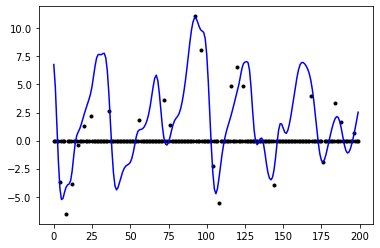

In [6]:
import matplotlib.pyplot as plt 
idx = 12
jj = 1
# Visualisation
plt.plot(X_train_obs[idx,jj,:], 'k.')
plt.plot(X_train[idx,jj,:],'b-')


In [7]:
np.savez('dataset/N' + str(sigNoise) + '_training_set', x_train_obs=x_train_obs, x_train=x_train, mask_train=mask_train, 
         x_val_obs=x_val_obs, x_val=x_val, mask_val=mask_val, std=stdTr, mean=meanTr)